# An Analysis of Wine Production, Consumption, Ratings and Price

### Part I - Historical Data Analyses
* Global Production and Consumption vs. Population Growth
* Historical Production, Export and Consumption for the top 10 producers in 2016
* Focus on the US

### Part II - Analyses of Ratings, Varieties, Origin and Price
* Blah
* Blah
* Blah
* Blah

In [205]:
#%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gmaps
import requests
import json
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
from plotly.offline import plot
from statistics import mean
from scipy.stats import sem
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib as mpl

from api_keys import (owmkey,gkey)
reportimagepath='../reports/images/'

## Part I - Analyzing global historial wine trade (Working on Giant MS-Excel File)¶
-Database source: Anderson, K. and V. Pinilla (with the assistance of A.J. Holmes), Annual Database of Global Wine Markets, 1835 to 2016, freely available in Excel at the University of Adelaide’s Wine Economics Research Centre, November 2017 www.adelaide.edu.au/wine-econ/databases/global-wine-history

#### The source file has over 100 sheets. For this study we used:
* T6 Volume of wine production
* T8 Volume of wine production per capita
* T10 Volume of wine exports
* T12 Volume of wine exports per capita
* T15 Volume of wine imports
* T17 Volume of wine imports per capita
* T34 Volume of wine consumption
* T38 Volume of wine consumption per capita
* T58 Population

### Data Wrangling- Part I

#### The follwoing function works as follows:
* Reads the name of worksheet within the giant Excel Worksheet (string) (required)
* Reads the number of rows to be removed from bottom (brr) and top (thr) (two integers) (optional)
* Removes unnecessary columns (e.g. Other column, Other Asia Pacific, Coeff. of variation)
* Relocate/Rename columns (i.e., Norway and Bel-Lux)
* Takes the year column as index
* Returns the cleaned dataframe with the year as index

In [4]:
# removing the unnecessary row from top or bottom
# relocating the columns and removing unnecessary ones
# reset indexing
def giant_worksheet(sheet_giant,brr=0, thr=0):
    
    df = pd.read_excel('../data/rawdata/Megafile_of_global_wine_data_1835_to_2016_1217.xlsx', 
                         sheet_name=sheet_giant, header=1, index_col=None)
    df.index.rename('year',inplace=True)
    df=df.reset_index()
    #df.fillna(-1,inplace=True) #fills empty cells with -1
    
    #relocating the Norway column if exist
    try:
        nor = df['Norway']
        df.drop(labels=['Norway'], axis=1,inplace = True)
        df.insert(6, 'Norway', nor)
    except:
        print('NO Norway column found in worksheet:', sheet_giant)

    #dfmf.drop(labels=['nan'], axis=1,inplace = True)
    df=df.rename(columns={'Bel-Lux':'Belgium'}) #chnage the name of Be-Lux to Belgium
    df.drop(labels=['Coeff. of variation'], axis=1,inplace = True) #remove the coeff of var column.
    df.drop(labels=['Other'], axis=1,inplace = True) #remove the Other column
    df.drop(labels=['Other Asia Pacific'], axis=1,inplace = True) #remove the Other column
    #df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

    row_to_drop=list(range(thr))
    df=df.drop(df.index[row_to_drop])
    if brr !=0:
        df=df[:-brr]
    df.set_index('year',inplace=True)
    print('Worksheet: {} wrangling completed!'.format(sheet_giant))
    return df

Pass each worksheet to the giant_worksheet function and save the dataframe to a worksheet of a MS-Excel Workbook called Wine_History.xlsx

In [5]:
outputpath="..\data\cleandata\Wine_History.xlsx"
writer = pd.ExcelWriter(outputpath, engine='xlsxwriter')


#Wine production volume(dfwpv) (KL) (ws #6)
sheetname='T6 Wine production'
dfwpv=giant_worksheet(sheet_giant=sheetname,thr=30)
dfwpv.to_excel(writer, sheet_name=sheetname)

#wine production per capita (dfwppc) (litres) (ws #8)
sheetname='T8 Wine prodn per capita'
dfwppc=giant_worksheet(sheet_giant=sheetname,thr=30,brr=3)
dfwppc.to_excel(writer, sheet_name=sheetname)

#wine production per capita (dfwev) (KL) (ws #10)
sheetname='T10 Wine export vol'
dfwev=giant_worksheet(sheet_giant=sheetname,thr=30,brr=3)
dfwev.to_excel(writer, sheet_name=sheetname)

#Wine import volume(dfwiv) (KL) (ws #15)
sheetname='T15 Wine import vol'
dfwiv=giant_worksheet(sheet_giant=sheetname,thr=30)
dfwiv.to_excel(writer, sheet_name=sheetname)

#Wine consumption volume(dfwcv) (KL) (ws #34)
sheetname='T34 Wine consumption vol'
dfwcv=giant_worksheet(sheet_giant=sheetname,thr=30,brr=2)
dfwcv.to_excel(writer, sheet_name=sheetname)

#Wine consumption per capita (dfwcpc) (litres) (ws #38)
sheetname='T38 Wine consumption per capita'
dfwcpc=giant_worksheet(sheet_giant=sheetname,thr=30,brr=2)
dfwcpc.to_excel(writer, sheet_name=sheetname)

#Global population (dfgp) (*1000) (ws #58)
sheetname='T58 Population'
dfgp=giant_worksheet(sheet_giant=sheetname,thr=30)
dfgp.to_excel(writer, sheet_name=sheetname)


#Wine consumption intensity index (dfwcii) (ws #96)
sheetname='T96 Wine cons intensity index'
dfwcii=giant_worksheet(sheet_giant=sheetname, brr=15,thr=126)
dfwcii.to_excel(writer, sheet_name=sheetname)

writer.save()

NO Norway column found in worksheet: T6 Wine production
Worksheet: T6 Wine production wrangling completed!
NO Norway column found in worksheet: T8 Wine prodn per capita
Worksheet: T8 Wine prodn per capita wrangling completed!
NO Norway column found in worksheet: T10 Wine export vol
Worksheet: T10 Wine export vol wrangling completed!
Worksheet: T15 Wine import vol wrangling completed!
Worksheet: T34 Wine consumption vol wrangling completed!
Worksheet: T38 Wine consumption per capita wrangling completed!
Worksheet: T58 Population wrangling completed!
Worksheet: T96 Wine cons intensity index wrangling completed!


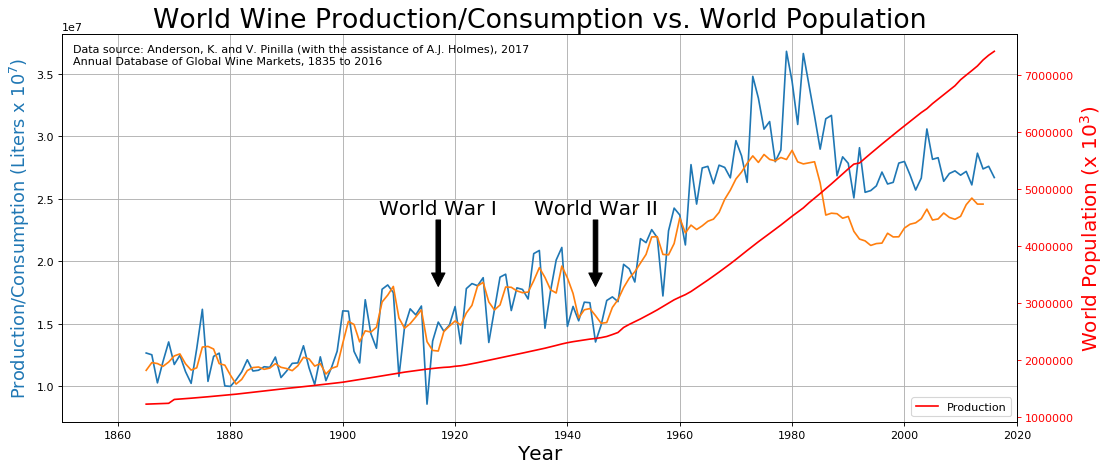

In [156]:
# --------------------------------------------------------------------
# Plotting World Production and World population 1850-2016
# --------------------------------------------------------------------

# World production in volume

# Main plot: global production and consumption
fig, ax1 = plt.subplots(figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
l1=ax1.plot(dfwpv.index,dfwpv.World, color='#1f77b4')
l2=ax1.plot(dfwcv.index,dfwcv.World, color='#ff7f0e')

ax1.grid()
# Arrows 
ax1.annotate('World War I', xy=(1917, 18000000), xycoords='data', xytext=(1917, 25000000), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=1),
            horizontalalignment='center', verticalalignment='top',fontsize=18)
ax1.annotate('World War II', xy=(1945, 18000000), xycoords='data', xytext=(1945, 25000000), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=1),
            horizontalalignment='center', verticalalignment='top',fontsize=18)
# Labels
ax1.set_xlabel('Year',fontsize=18)
ax1.set_ylabel('Production/Consumption (Liters x $10^7$)', color='#1f77b4',fontsize=16)

#plt.legend(["Production","Consumption"],loc="lower right")

# twinx allows to add data to the main plot, with the same x, but a different y scale
ax2 = ax1.twinx()
ax2.plot(dfgp.index,dfgp.World, color='r')
ax2.set_ylabel('World Population (x $10^3$)', color='r',fontsize=18)
ax2.tick_params('y', colors='r')

# Final plot title and x adjustment
plt.title("World Wine Production/Consumption vs. World Population",fontsize=24)
plt.xlim(left = 1850, right=2020)
# Required acknowledgement to the source
plt.text(1852,7200000,"Data source: Anderson, K. and V. Pinilla (with the assistance of A.J. Holmes), 2017\nAnnual Database of Global Wine Markets, 1835 to 2016")

#legend
plt.legend(["Production","Consumption"],loc="lower right")
fig.tight_layout()

# Output plot file
fignum=1
plt.savefig(reportimagepath+str(fignum)+"- World Wine Production and Consumption vs World Population.png",bbox_inches="tight")
fignum+=1
plt.show()

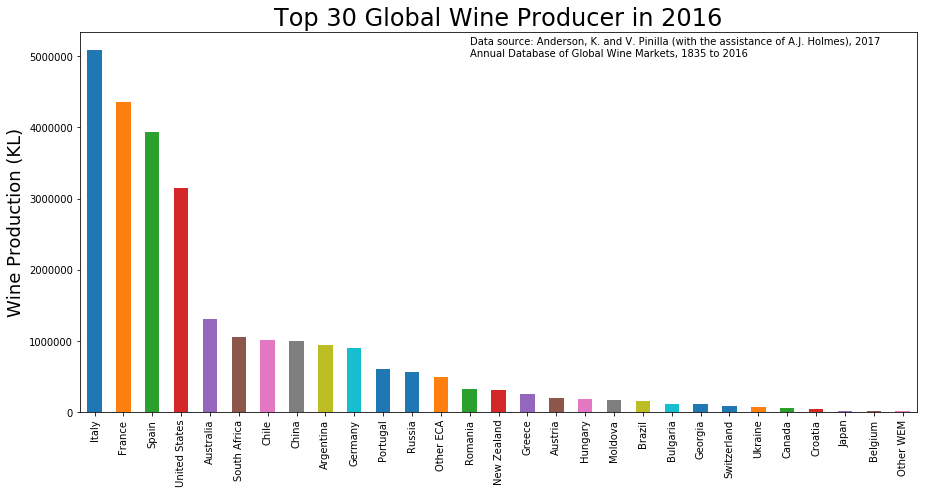

In [157]:
# --------------------------------------------------------------------
# Plotting Top 30 Global Wine Producers in 2016
# --------------------------------------------------------------------

ax3=dfwpv.loc[2016].sort_values(ascending=False)[1:30].plot(kind='bar',figsize=(15,7))
plt.title("Top 30 Global Wine Producer in 2016", fontsize=24)
# Required acknowledgement to the source
plt.text(13,5000000,"Data source: Anderson, K. and V. Pinilla (with the assistance of A.J. Holmes), 2017\nAnnual Database of Global Wine Markets, 1835 to 2016")
ax3.set_ylabel("Wine Production (KL)",fontsize=18)
fig.tight_layout()

# Output plot file
plt.savefig(reportimagepath+str(fignum)+"-Wine Production by Volume - Top 30 Producing Countries.png",bbox_inches="tight")
fignum+=1

This function reads the dataframe, chart title, and y-axis label, and return the plot for the list of countries

In [158]:
def wine_pc(fignum,df,countries, title, yax_name):
    # Comparison of Historical Wine Production per Capita for top 10 producers
    #Top 10 wine producer in 2016
    fig, ax1 = plt.subplots(figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
    for x in countries:
        ax1.plot(df.index,df[x])

    plt.ylim(top=max(df[x].max() for x in countries)*1.2)
    plt.title(title+'- Top 10 Producing Countries',fontsize=24)
    plt.xlabel("Year",fontsize=18)
    plt.ylabel(yax_name,fontsize=18)
    plt.text(mean(df.index.tolist())-40,max(df[x].max() for x in countries)*1.1,"Data source: Anderson, K. and V. Pinilla (with the assistance of A.J. Holmes), 2017\nAnnual Database of Global Wine Markets, 1835 to 2016")
    plt.legend()

    # Output plot file
    plt.savefig("../reports/images/"+str(fignum)+'-'+title+'.png',bbox_inches="tight")

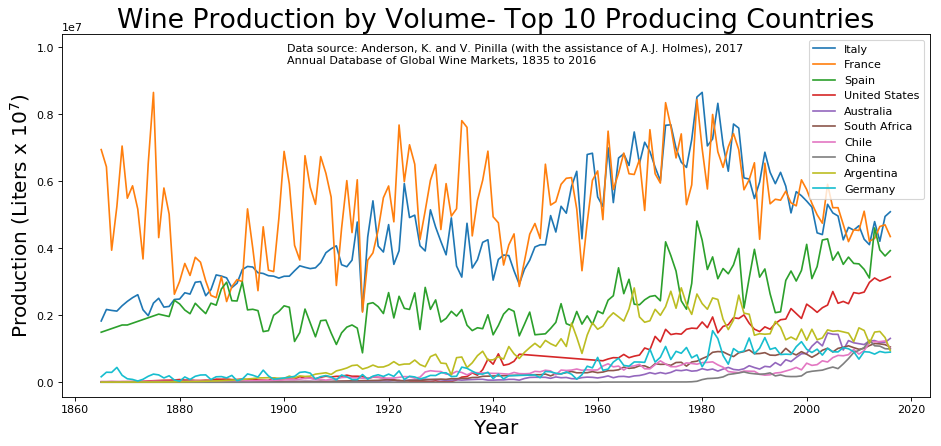

In [159]:
# Comparison of Historical Wine Production for top 10 producers

#Top 10 wine producer in 2016
countries=dfwpv.loc[2016].sort_values(ascending=False)[1:11].index

# Wine production volume
wine_pc(fignum,dfwpv, countries, "Wine Production by Volume",'Production (Liters x $10^7$)')
fignum+=1

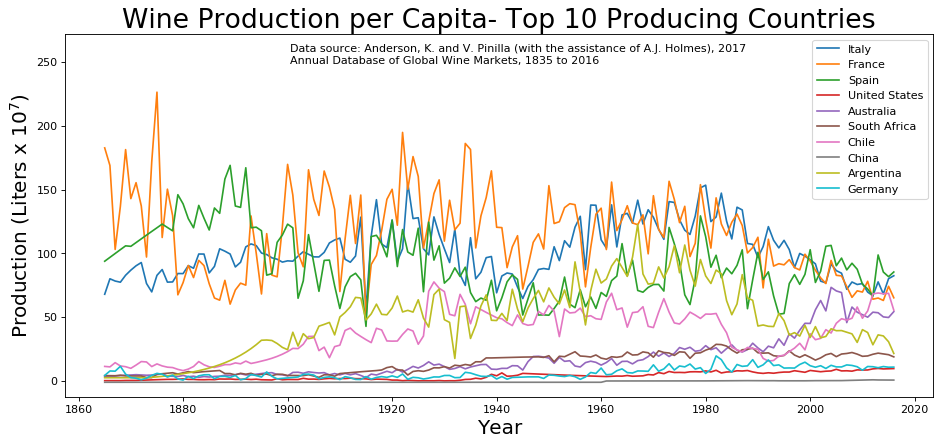

In [160]:
# Wine production per capita
wine_pc(fignum, dfwppc, countries, "Wine Production per Capita",'Production (Liters x $10^7$)')
fignum+=1

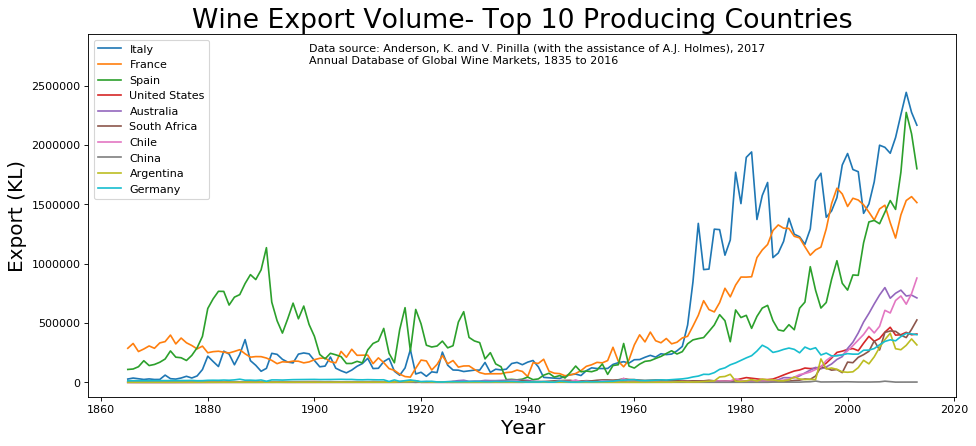

In [161]:
# Comparison of Wine Export Volumes for the top 10 producers
wine_pc(fignum, dfwev, countries, "Wine Export Volume","Export (KL)")
fignum+=1

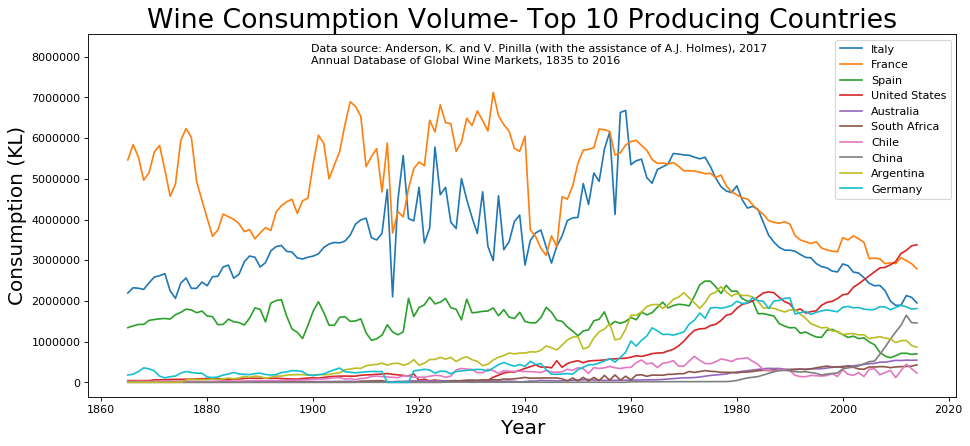

In [162]:
# Comparison of Wine Consumption for the top 10 producers
wine_pc(fignum, dfwcv, countries, "Wine Consumption Volume","Consumption (KL)")
fignum+=1

Worksheet: T38 Wine consumption per capita wrangling completed!


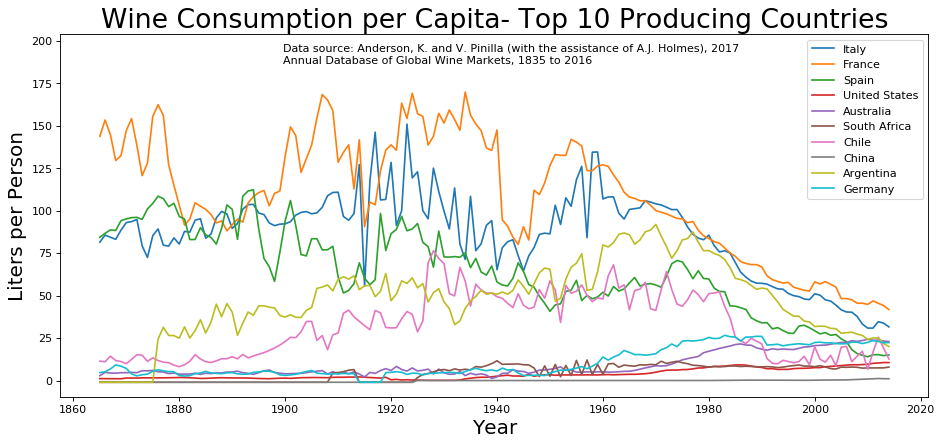

In [163]:
#Wine consumption per capita (dfwcpc) (litres) (ws #38)
sheetname='T38 Wine consumption per capita'
dfwcpc=giant_worksheet(sheet_giant=sheetname,thr=30,brr=2)
dfwcpc.to_excel(writer, sheet_name=sheetname)
# Comparison of Wine Consumption per capita for the top 10 producers
wine_pc(fignum, dfwcpc, countries, "Wine Consumption per Capita","Liters per Person")
fignum+=1

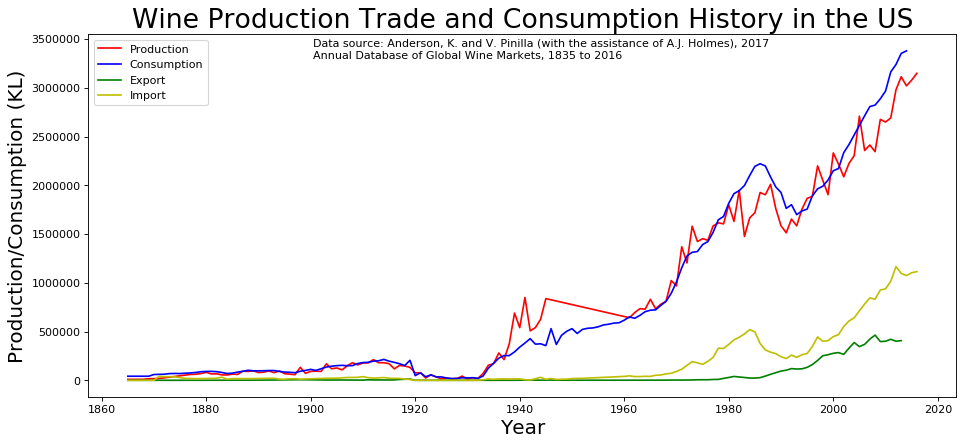

In [164]:
# =============
# = US only:  =
# =============

x='United States'
title='Wine Production Trade and Consumption History in the US'
fig, ax1 = plt.subplots(figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
l1=ax1.plot(dfwpv.index,dfwpv[x],color='r')
l2=ax1.plot(dfwcv.index,dfwcv[x],color='b')
l3=ax1.plot(dfwev.index,dfwev[x],color='g')
l4=ax1.plot(dfwiv.index,dfwiv[x],color='y')

#plt.ylim(top=max(df[x].max() for x in countries)*1.2)
plt.title(title,fontsize=24)
plt.xlabel("Year",fontsize=18)
plt.ylabel('Production/Consumption (KL)',fontsize=18)
plt.text(mean(dfwpv.index.tolist())-40,3300000,"Data source: Anderson, K. and V. Pinilla (with the assistance of A.J. Holmes), 2017\nAnnual Database of Global Wine Markets, 1835 to 2016")
plt.legend(["Production","Consumption","Export","Import"],loc='best')

# Output plot file
plt.savefig("../reports/images/"+str(fignum)+"-"+title+".png",bbox_inches="tight")
fignum+=1
plt.show()

# Part II - Analyzing Wine Price/Rating/Variety (Working on 130K MS-Excel File)

### Data Wrangling- Part II
#### 1) Import data from 130k Excel workbook
#### 2) Cleaning up the data (e.g. remow null values, tester twitter column),  and 
#### 3) Export the data back to another csv file
#### Note: It reduced the number of studied wines from 129970 to 120916

In [25]:
file_one = "../data/rawdata/winemag-data-130k-v2.csv"
df = pd.read_csv(file_one,index_col=0)
#cleaning data: delete the taster_tweeter address column
df.drop(columns=['taster_twitter_handle'])
#drop any null values
df = df.dropna(subset=['country','points','price'])
df.sort_values(by=['price'],ascending=False)
df.to_csv(path_or_buf="..\data\cleandata\Wine_price_rating_variety.csv")

## Categorize more than 700 wine types to 9 majors and 77 sub-categories:
1) Bold Red: Malbec, Syrah, Shiraz, Mourvedre, Pinotage, Petite Sirah, Touriga Nacional, Cabernet Sauvignon, Bordeaux Blend, Meritage

2) Medium Red: Meriot, Sangiovese, Zinfandel, Cabernet Franc, Tempranillo, Nebbiolo, Barbera, Cotes du Rhone Blend

3) Light Red: Pinot Noir, Grenache, Gamay, St. Laurent, Carignan, Counoise

4) Rich White: Chardonnay, Semillon, Viognier, Marsanne, Roussanne

5) Light White: Sauvignon Blanc, Albarino, Pitot Blanc, Vermentino, Melon de Bourgogne, Gargenega, Trebbiano, Pinot Gris, Pinot Grigio, Veltliner

6) Rose: Provencal Rose, White Zinfandel, Loire Valley Rose, Pinot Noir Rose, Syrah Rose, Garnache Rosado, Bandol Rose, Tempranilio Rose, Saignee Method Rose

7) Sweet White: Moscato, Riesling, Chenin Blanc, Gewurztraminer, Late Harvest Whites, Alascian Pinot Gris

8) Sparkling: Champagne, Prosecco, Cremant, Cava, Metodo Classico, Sparkling Wine, Sparkling Rose

9) Dessert: Port, Sherry, Maderia, Vin Santo, Muscat, PX, Pedro Ximenez

In [125]:
Wine_types={'Bold Red': ['Malbec', 'Syrah','Red Blend','Shiraz', 'Mourvedre', 'Merlot','Bordeaux-style Red Blend', 'Pinotage', 'Petite Sirah', 'Touriga Nacional', 'Cabernet Sauvignon', 'Portuguese Red', 'Meritage'],
            'Medium Red': ['Meriot', 'Sangiovese', 'Rhône-style Red Blend','Zinfandel','Cabernet Franc', 'Tempranillo', 'Nebbiolo', 'Barbera', 'Cotes du Rhone Blend'],
            'Light Red':['Pinot Noir', 'Grenache', 'Gamay', 'St. Laurent', 'Carignan', 'Counoise'],
            'Rich White': ['Chardonnay', 'Semillon','Viognier', 'Marsanne', 'Roussanne'],
            'Light White': ['Bordeaux-style White Blend','Sauvignon Blanc', 'White Blend' , 'Albarino', 'Pitot Blanc', 'Vermentino', 'Melon de Bourgogne', 'Gargenega', 'Trebbiano', 'Pinot Gris', 'Pinot Grigio', 'Veltliner'],
            'Sweet White': ['Moscato', 'Riesling', 'Chenin Blanc', 'Gewurztraminer', 'Late Harvest Whites', 'Alascian Pinot Gris'],
            'Rosé': ['Rosé','Provencal Rose', 'White Zinfandel', 'Loire Valley Rose', 'Pinot Noir Rose', 'Syrah Rose', 'Garnache Rosado', 'Bandol Rose', 'Tempranilio Rose', 'Saignee Method Rose'],
            'Sparkling': ['Champagne', 'Prosecco', 'Cremant', 'Cava', 'Metodo Classico', 'Sparkling Wine', 'Sparkling Rose', 'Sparkling Blend', 'Champagne Blend'],
            'Dessert': ['Port', 'Sherry', 'Maderia', 'Vin Santo', 'Muscat', 'PX', 'Pedro Ximenez']
           }
Wine_types.keys()
for x in Wine_types.keys():
    for y in range(len(Wine_types[x])):
        print('type=',x,'subtype=',Wine_types[x][y])
        A=df[df.variety.str.contains(Wine_types[x][y],na=False)].index.tolist()
        df.loc[A,'vt']=x
idx = df['vt'].isnull( )
df.loc[idx,'vt']='Others'
df.to_csv(path_or_buf="..\data\cleandata\Wine_price_rating_variety.csv")
df.head()

type= Bold Red subtype= Malbec
type= Bold Red subtype= Syrah
type= Bold Red subtype= Red Blend
type= Bold Red subtype= Shiraz
type= Bold Red subtype= Mourvedre
type= Bold Red subtype= Merlot
type= Bold Red subtype= Bordeaux-style Red Blend
type= Bold Red subtype= Pinotage
type= Bold Red subtype= Petite Sirah
type= Bold Red subtype= Touriga Nacional
type= Bold Red subtype= Cabernet Sauvignon
type= Bold Red subtype= Portuguese Red
type= Bold Red subtype= Meritage
type= Medium Red subtype= Meriot
type= Medium Red subtype= Sangiovese
type= Medium Red subtype= Rhône-style Red Blend
type= Medium Red subtype= Zinfandel
type= Medium Red subtype= Cabernet Franc
type= Medium Red subtype= Tempranillo
type= Medium Red subtype= Nebbiolo
type= Medium Red subtype= Barbera
type= Medium Red subtype= Cotes du Rhone Blend
type= Light Red subtype= Pinot Noir
type= Light Red subtype= Grenache
type= Light Red subtype= Gamay
type= Light Red subtype= St. Laurent
type= Light Red subtype= Carignan
type= Light R

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vt
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,$15.00,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Dessert
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,$14.00,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,Light White
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,$13.00,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,Sweet White
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,$65.00,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,Light Red
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,$15.00,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,Medium Red


### Most Popular Wines by Variety: Piechart

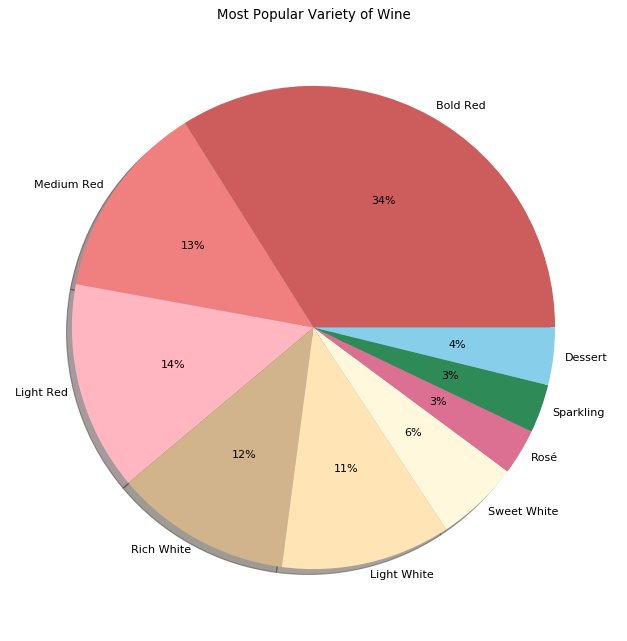

In [200]:
figname=9
A= {}
for x in Wine_types.keys():
    A.update({x: df[df.vt==x].vt.count()})

colors = [ 'Indianred', 'lightcoral', 'lightpink', 'tan', 'moccasin', 'cornsilk', 'palevioletred', 'seagreen', 'skyblue']

fig,ax=plt.subplots(figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')    
l1=ax.pie(A.values(), shadow=True,labels=A.keys(), colors=colors, autopct="%1.00f%%",labeldistance=1.05)
ax.set_title("Most Popular Variety of Wine")
plt.savefig("../reports/images/"+str(fignum)+"-Distribution_of_Wine_Ratings.png",bbox_inches="tight")
fignum+=1

### Most Popular Wine Types by Price: Mean and Max

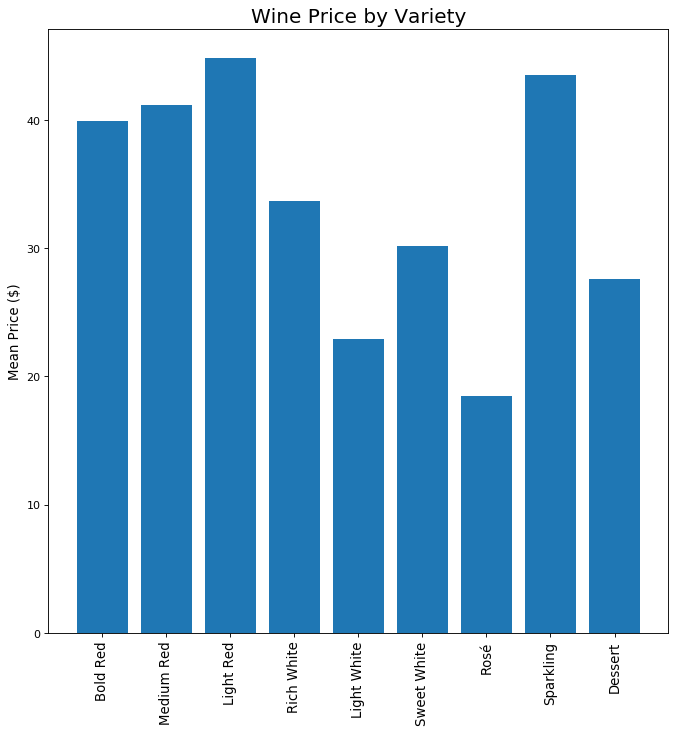

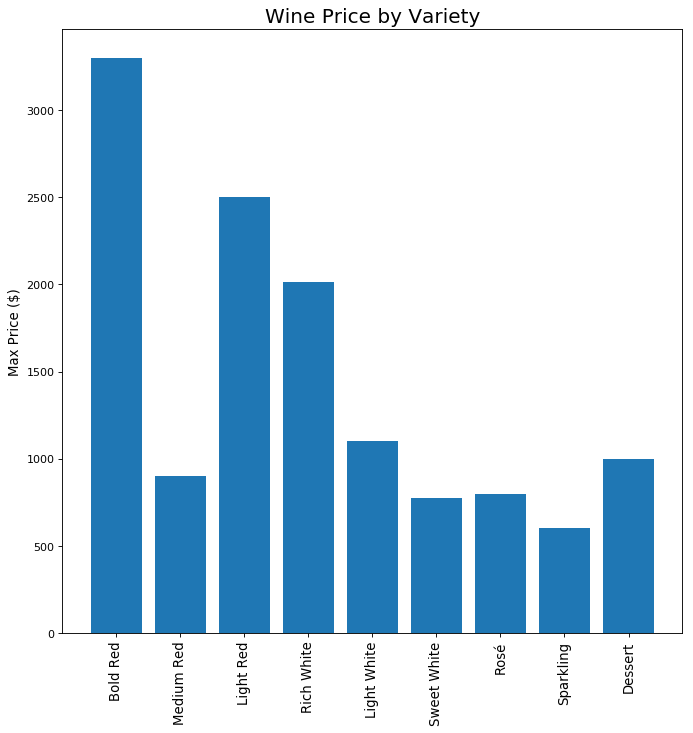

In [169]:
#Bar chart for most popular wine types by mean price
A= {}
for x in Wine_types.keys():
    A.update({x: df[df.vt==x].price.mean()})

fig,ax1=plt.subplots(figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')
l1=ax1.bar(Wine_types.keys(), A.values())
ax1.set_title("Wine Price by Variety",fontsize=18)
plt.ylabel("Mean Price ($)",fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.savefig("../reports/images/"+str(fignum)+"-Most_Popular_Wine_Types_by_Price_Mean.png",bbox_inches="tight")
fignum+=1

A= {}
for x in Wine_types.keys():
    A.update({x: df[df.vt==x].price.max()})
    
fig,ax2=plt.subplots(figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')
l1=ax2.bar(Wine_types.keys(), A.values())
ax2.set_title("Wine Price by Variety",fontsize=18)
plt.ylabel("Max Price ($)",fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.savefig("../reports/images/"+str(fignum)+"-Most_Popular_Wine_Types_by_Price__Max.png",bbox_inches="tight")
fignum+=1

### Most Popular Wines by Country: Piechart

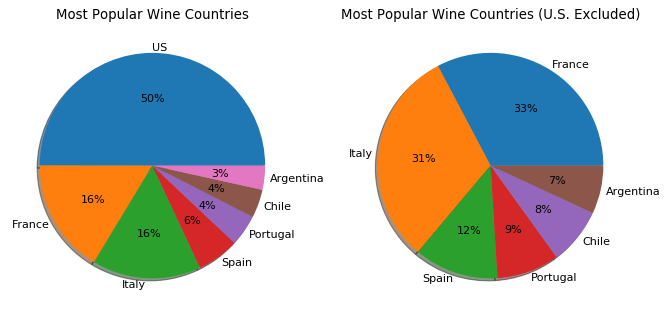

In [170]:
#pie chart for most popular wine producer countries (U.S. included: left, U.S. excluded: right)
top_con=df.country.value_counts().head(7)

A= {}
for x in top_con.index:
    A.update({x: top_con[x]})

fig=plt.figure(figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')
ax1=fig.add_subplot(1,2,1)    
l1=ax1.pie(A.values(), shadow=True,labels=A.keys(), autopct="%1.00f%%",labeldistance=1.05)
ax1.set_title("Most Popular Wine Countries")

A= {}
for x in top_con.index[1:]:
    A.update({x: top_con[x]})
ax2=fig.add_subplot(1,2,2)    
l1=ax2.pie(A.values(), shadow=True,labels=A.keys(), autopct="%1.00f%%",labeldistance=1.05)
ax2.set_title("Most Popular Wine Countries (U.S. Excluded)")
plt.savefig("../reports/images/"+str(fignum)+"-Most_Popular_Wine_by_Country.png",bbox_inches="tight")
fignum+=1

### Average and Maximum Wine Cost and Rating for the Top 7 Countries with the most amount of wines 

In [123]:
pd.options.display.float_format = '${:,.2f}'.format
A=pd.DataFrame(columns=['country','Mean_Wine_price', 'Mean_Wine_Rating'])
for x in range(len(top_con.index)):
    A.loc[x]=[top_con.index[x], 
              df[df.country==top_con.index[x]].price.mean(),
              df[df.country==top_con.index[x]].points.mean()]
A.set_index('country',inplace=True)

,Mean_Wine_price,Mean_Wine_Rating
country,,
US,$36.57,$88.57
France,$41.14,$88.73
Italy,$39.66,$88.62
Spain,$28.22,$87.29
Portugal,$26.22,$88.32
Chile,$20.79,$86.50
Argentina,$24.51,$86.71


### Most Expensive Wines by Variety and Country

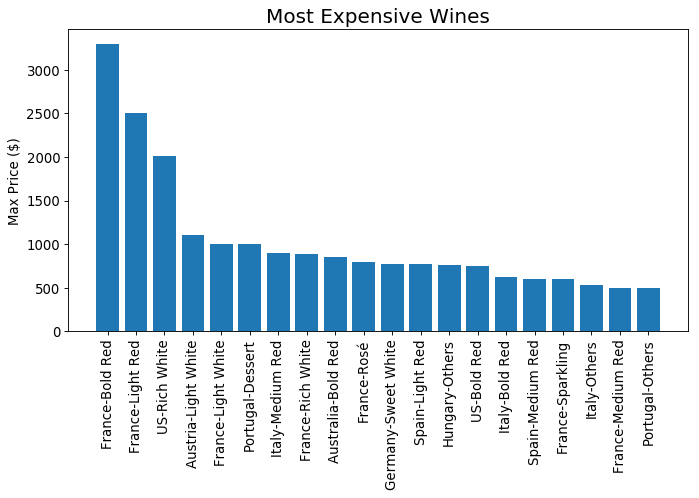

In [174]:
dfcvt=df.pivot_table(index=['vt','country'],values=['price','points'],aggfunc=[np.mean,np.max,np.min])
dfcvt.columns = list(map("_".join, dfcvt.columns))
dfcvt['wine_count']=df.groupby(['vt','country'])['price'].apply(lambda x: x.count())
dfcvt.sort_values(by=['amax_price'],ascending=False,inplace=True)

A=dfcvt.head(20)
B=A[['mean_price','amax_price']]
B.reset_index(inplace=True)

fig, ax= plt.subplots(num=1,figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
l1= ax.bar([x+'-'+y for x,y in zip(B.country,B.vt)], B.amax_price)
plt.ylim([0,B.amax_price.max()*1.05])
plt.xticks(rotation=90, fontsize=5)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.xticks(rotation=90)
plt.ylabel("Max Price ($)",fontsize=12)
plt.title("Most Expensive Wines",fontsize=18)
plt.savefig("../reports/images/"+str(fignum)+"-Most_Expensive_Wines.png",bbox_inches="tight")
fignum+=1

### Price and Point Statistics for all Wine Types

In [145]:
dfvt=df.pivot_table(index=['vt'],values=['price','points'],aggfunc=[np.mean,np.max,np.min])
dfvt.columns = list(map("_".join, dfvt.columns))
dfvt['wine_count']=df.groupby(['vt'])['price'].apply(lambda x: x.count())
dfvt.sort_values(by=['amax_price'],ascending=False,inplace=True)
dfvt

,mean_points,mean_price,amax_points,amax_price,amin_points,amin_price,wine_count
vt,,,,,,,
Bold Red,$88.47,$39.90,100,"$3,300.00",80,$4.00,35983
Light Red,$89.30,$44.85,99,"$2,500.00",80,$5.00,14829
Rich White,$88.25,$33.69,100,"$2,013.00",80,$4.00,12512
Light White,$87.75,$22.90,100,"$1,100.00",80,$4.00,12028
Dessert,$88.49,$27.63,100,"$1,000.00",80,$5.00,4068
Medium Red,$88.63,$41.18,100,$900.00,80,$4.00,13985
Rosé,$86.89,$18.51,96,$800.00,80,$5.00,3261
Sweet White,$89.14,$30.14,99,$775.00,80,$5.00,5930
Others,$87.91,$26.99,100,$764.00,80,$5.00,14881


### Probability distribution of wine ratings

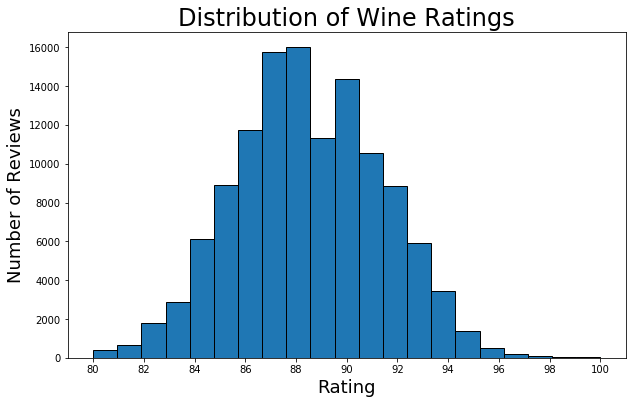

In [178]:
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df.points, 21, edgecolor='k',histtype='bar')
plt.xticks(range(80,101,2))
plt.xlabel('Rating',fontsize=18)
plt.ylabel('Number of Reviews',fontsize=18)
plt.title('Distribution of Wine Ratings',fontsize=24)
plt.savefig("../reports/images/"+str(fignum)+"-Distribution_of_Wine_Ratings.png",bbox_inches="tight")
fignum+=1

###  !! Ratings seem to follow a normal distribution, lets fit our data using that distribution and see how well it fits.

### Probability distribution of taster ratings

C:\Users\beygi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning:

scipy.stats.norm.pdf



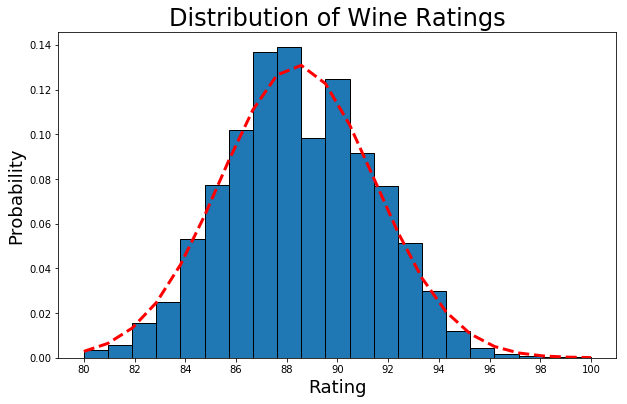

In [185]:
# Plot probability distribution for taster ratings
plt.figure(figsize=(10,6))
num_bins = 21
(mu, sigma) = norm.fit(df.points)
n, bins, patches = plt.hist(x, num_bins, density=1, edgecolor='k',histtype='bar')
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=3)
plt.xticks(range(80,101,2))
plt.xlabel('Rating',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.title('Distribution of Wine Ratings',fontsize=24)
plt.savefig("../reports/images/"+str(fignum)+"_Fit_Distribution_of_Wine_Ratings.png",bbox_inches="tight")
fignum+=1
plt.show()

#### !! The average rating for all tasters fall inside one standard deviation from the mean. We do not see a reviewer diverting significantly from the mean. We have also look at box plots

# Do tasters show a preference to review certain wine varieties? 

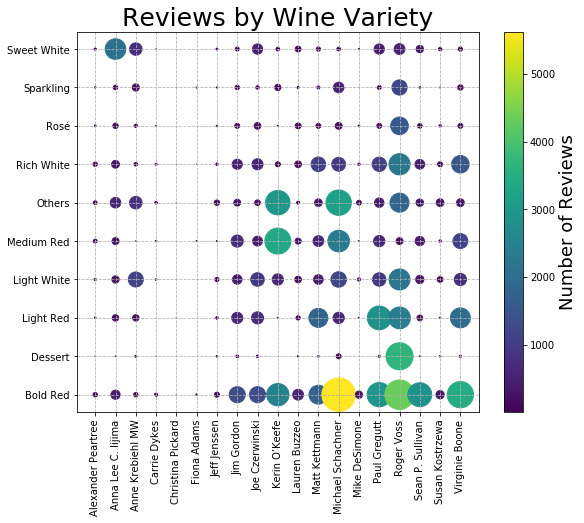

In [197]:
fignum=16
# Groping by tasters and variety
A = df.groupby(['taster_name','vt'])['points'].count()
A=A.reset_index()
# Create a scatter plot of variety and tasters
plt.figure(figsize=(9,7))
plt.scatter(A.taster_name,A.vt,s=A.points*.2,c=A.points)
plt.xticks(rotation=90)
plt.grid(linestyle='--')
cbar=plt.colorbar()
cbar.set_label('Number of Reviews', size=18)
plt.title('Reviews by Wine Variety',fontsize=25)
plt.savefig("../reports/images/"+str(fignum)+"_Review_by_Wine_Variety.png",bbox_inches="tight")
fignum+=1
plt.show()

### !! We see that tasters tend to review wines across several varieties and although not in equal numbers.

# Do tasters show a preference to review wines from specific countries?

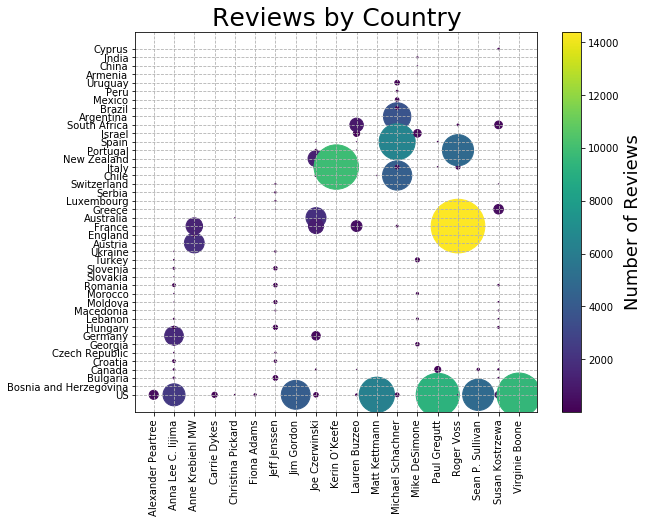

In [199]:
# Groping by tasters and country
A = df.groupby(['taster_name','country'])['points'].count()
A=A.reset_index()
# Create a scatter plot of variety and tasters
plt.figure(figsize=(9,7))
plt.scatter(A.taster_name,A.country,s=A.points*.2,c=A.points)
plt.xticks(rotation=90)
plt.grid(linestyle='--')
cbar=plt.colorbar()
cbar.set_label('Number of Reviews', size=18)
plt.title('Reviews by Country',fontsize=25)
plt.savefig("../reports/images/"+str(fignum)+"_Review_by_Country.png",bbox_inches="tight")
fignum+=1
plt.show()

### !! We do see that tasters tend to favor reviewing wines from specific countries. For example, Virginie Boone and Kerin O'keefe have both reviwed wine from one country and Roger Voss has mode over 10,000 reviews the vast majority for wines from France and Portugal.

## Price and Points Correlation

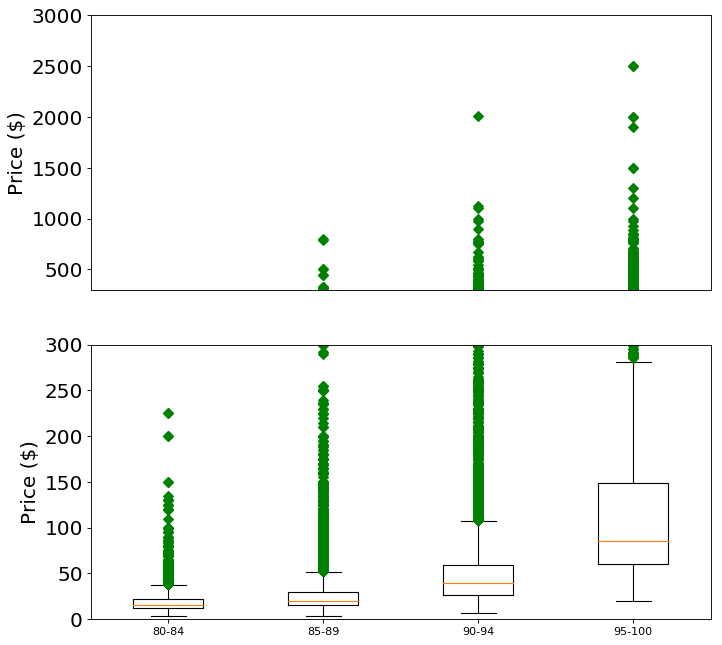

In [221]:
fignum=18
#extract points and price columns
df_numeric=df._get_numeric_data()

#making bins in which Data will be held and creating a group based off of the bins
bins = [80,85,90,95,101]

# Create the names for the four bins
group_names = ['80-84','85-89','90-94','95-100']
df_numeric["points_avg"] = pd.cut(df_numeric["points"], bins, labels=group_names, right=False)
df_bins = df_numeric.groupby("points_avg",as_index=False)

#plot the categorized data in four bins 
mpl.rc('ytick',labelsize=18)

tick_labels =list(df_bins.groups.keys())
A=[]
for keys in tick_labels:
    A.append(df_bins.get_group(keys).price)

fig=plt.figure(figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')
ax1=fig.add_subplot(2,1,1)  
ax1.boxplot(A,0,'gD')
ax1.set_xticklabels(tick_labels)
ax1.set_xlabel('Points',fontsize=18)
ax1.set_ylabel('Price ($)',fontsize=18)
ax1.set_ylim(300,3000)
ax1.axes.get_xaxis().set_visible(False)

ax2=fig.add_subplot(2,1,2) 
ax2.boxplot(A,notch=False,sym='gD',vert=True,whis=1.5)
ax2.set_xticklabels(tick_labels)
ax2.set_ylabel('Price ($)',fontsize=18)
ax2.set_ylim(0,300)



#df_bins.describe()
plt.savefig("../reports/images/"+str(fignum)+"_Price_Points_correlation.png",bbox_inches="tight")
fignum+=1